In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import matplotlib.pyplot as plt
from keras.applications.densenet import DenseNet121, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense
from keras.optimizers import Adam
#from generator import DataGenerator
import keras
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import seaborn as sn
from sklearn.metrics import classification_report

In [5]:
data_dir = "../input/kermany2018/OCT2017 /"
train_data_dir= '../input/kermany2018/OCT2017 /train/'
val_data_dir= '../input/kermany2018/OCT2017 /val/'
test_data_dir= '../input/kermany2018/OCT2017 /test/'
img_width, img_height = 224, 224 
channels = 3
batch_size = 32

In [6]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    zoom_range= (0.73, 0.9),
    horizontal_flip= True,
    rotation_range= 10,
    width_shift_range= 0.10,
    fill_mode= 'constant',
    height_shift_range= 0.10,   
    brightness_range= (0.55, 0.9),
)
valid_test_datagen = ImageDataGenerator(
    rescale= 1./255, 
)

In [7]:
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    shuffle= True, 
    seed= 1337
) 
valid_generator = valid_test_datagen.flow_from_directory(
    val_data_dir,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    shuffle= True, 
    seed= 1337
)

test_generator = valid_test_datagen.flow_from_directory(  
    test_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,        
    class_mode= 'categorical',
    shuffle= False, 
)


Found 83484 images belonging to 4 classes.
Found 32 images belonging to 4 classes.
Found 968 images belonging to 4 classes.


In [8]:
t_x, t_y = next(train_generator)

In [9]:
def inception_v3():
    img_in = Input(t_x.shape[1:])              #input of model 
    model =  InceptionV3(include_top= False , # remove  the 3 fully-connected layers at the top of the network
                weights='imagenet',      # pre train weight 
                input_tensor= img_in, 
                input_shape= t_x.shape[1:],
                pooling ='avg') 
    x = model.output  
    predictions = Dense(4, activation="softmax", name="predictions")(x)    # fuly connected layer for predict class 
    model = Model(inputs=img_in, outputs=predictions)
    return model

In [10]:
model = inception_v3()
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['accuracy'])

87916544/87910968 [==============================] - 1s 0us/step


In [11]:
checkpoint = ModelCheckpoint(
    'baseline_model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)

csvlogger = CSVLogger(
    filename= "baseline_training_csv.log",
    separator = ",",
    append = False
)

reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint, earlystop, csvlogger,reduceLR]

In [12]:
num_classes = len(train_generator.class_indices)  
train_labels = train_generator.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)
valid_labels = valid_generator.classes 
valid_labels = to_categorical(valid_labels, num_classes=num_classes)
nb_train_samples = len(train_generator.filenames)  
nb_valid_samples = len(valid_generator.filenames)
nb_test_samples = len(test_generator.filenames)

In [13]:
history = model.fit(
    train_generator, 
    epochs = 30,
    steps_per_epoch = nb_train_samples//batch_size,
    validation_data = valid_generator, 
    validation_steps = nb_valid_samples//batch_size,
    verbose = 2,
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/30
2608/2608 - 2058s - loss: 0.2374 - accuracy: 0.9212 - val_loss: 0.7105 - val_accuracy: 0.8750

Epoch 00001: val_loss improved from inf to 0.71047, saving model to baseline_model.h5
Epoch 2/30
2608/2608 - 1518s - loss: 0.1725 - accuracy: 0.9426 - val_loss: 0.0536 - val_accuracy: 1.0000

Epoch 00002: val_loss improved from 0.71047 to 0.05358, saving model to baseline_model.h5
Epoch 3/30
2608/2608 - 1470s - loss: 0.1550 - accuracy: 0.9477 - val_loss: 0.0933 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.05358
Epoch 4/30
2608/2608 - 1513s - loss: 0.1419 - accuracy: 0.9531 - val_loss: 0.0556 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 0.05358
Epoch 5/30
2608/2608 - 1531s - loss: 0.1291 - accuracy: 0.9560 - val_loss: 2.1032 - val_accuracy: 0.6250

Epoch 00005: val_loss did not improve from 0.05358

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 00005: early stopping


In [14]:
(eval_loss, eval_accuracy) = model.evaluate(test_generator, batch_size= batch_size, verbose= 1)
print('Test Loss: ', eval_loss)
print('Test Accuracy: ', eval_accuracy)

31/31 [==============================] - 11s 373ms/step - loss: 2.3727 - accuracy: 0.5899
Test Loss:  2.3727242946624756
Test Accuracy:  0.5898760557174683


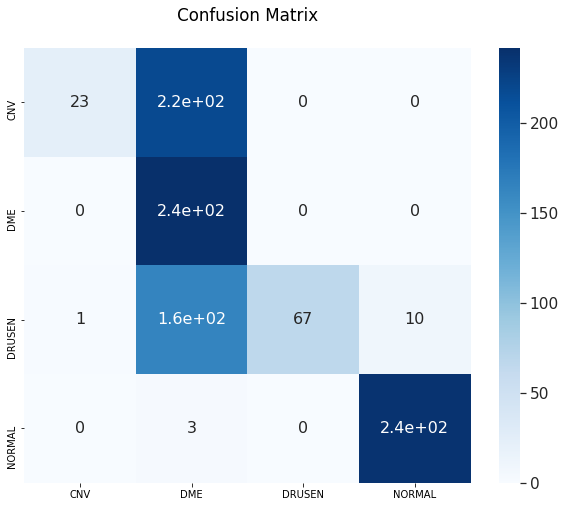

Classification Report

              precision    recall  f1-score   support

         CNV       0.96      0.10      0.17       242
         DME       0.39      1.00      0.56       242
      DRUSEN       1.00      0.28      0.43       242
      NORMAL       0.96      0.99      0.97       242

    accuracy                           0.59       968
   macro avg       0.83      0.59      0.53       968
weighted avg       0.83      0.59      0.53       968



In [15]:
Y_pred = model.predict(test_generator, nb_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)
df_cm = pd.DataFrame(cm, list(test_generator.class_indices.keys()), list(test_generator.class_indices.keys()))
fig, ax = plt.subplots(figsize=(10,8))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap=plt.cm.Blues)
plt.title('Confusion Matrix\n')
plt.savefig('confusion_matrix.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()
print('Classification Report\n')
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))